# Preprocessing
This process includes 
1. Downloading the dataset from online repository to local folder
2. Downloading and importing required libraries
3. Cropping the wave file into separate files by extracting the non-silent regions

In [ ]:
#Note: Run only once
#Install librosa to host, a python package for music and audio analysis.
!pip install librosa

#Install gdown, a python library for downloading files from Google Drive (public folder)
!pip install gdown -U --no-cache-dir

#### Download the dataset from Google Drive to the local folder

In [ ]:
import gdown
url = 'https://drive.google.com/drive/folders/1rDbrXwWj6smXSmK3EkkxUTkP4AtauEK8'
gdown.download_folder(url)

#### Import required libraries

In [19]:
import os #module that provides a portable way of using operating system dependent functionality (e.g., open, path, etc.)
import librosa #python package for music and audio analysis
import librosa.display #from librosa package, constructs a plot which adaptively switches between a raw samples-based view of the signal 
import numpy as np #library used for working with arrays
import matplotlib.pyplot as plt #a state-based interface to matplotlib. It provides an implicit, MATLAB-like, way of plotting.
import shutil #offers a number of high-level operations on files and collections of files (e.g., rmtree, copy, etc.)
from pydub import AudioSegment #are *immutable* objects representing segments of audio that can be manipulated using python code.
from pydub.silence import split_on_silence #Returns list of audio segments from splitting audio_segment on silent sections
from glob import glob #finds all the pathnames matching a specified pattern
import pandas as pd #for data manipulation and analysis.

#### Cropping the wave file into separate files by extracting the non-silent regions

##### Loading audio files with Librosa

In [20]:
scale_file = "audio/scale.wav"
guitar_major = "audio/Guitar Major.wav"
guitar_minor = "audio/Guitar Minor.wav"
dPiano_major = "audio/Digital Piano Major.wav"
dPiano_minor = "audio/Digital Piano Minor.wav"

##### Crop Function

In [21]:
path = "Audio Chunks" #set the directory
if not os.path.exists(path): #if the path does not exists, create a folder
    os.makedirs(path)
else: #else, remove the folder then create to have a new copy every run
    shutil.rmtree(path)
    os.makedirs(path)
    
#Function to split the wave files into non-silent regions
#Input: wave file, file name
#Output: Cropped wave files (removed silent regions)
def chunk(file, name):
    sound_file = AudioSegment.from_wav(file)
    audio_chunks = split_on_silence(sound_file, min_silence_len=500, silence_thresh=-40 )
    
    for i, chunk in enumerate(audio_chunks):
        out_file = "Audio Chunks/"+ name +"_{0}.wav".format(i+1)
        print("exporting", out_file)
        chunk.export(out_file, format="wav")

##### Crop the wave files

In [ ]:
chunk(dPiano_major, "Digital Piano Major")
chunk(dPiano_minor, "Digital Piano Minor")
chunk(guitar_major, "Guitar Major")
chunk(guitar_minor, "Guitar Minor")

# Major Function Definition
These are the Functions that are crucial for audio analysis:
1. Extracting STFT
2. Calculate Spectrogram
3. Get Power Spectrogram
4. Get Amplitude Spectrogram
5. Plotting the Spectrogram

#### Extracting Short-Time Fourier Transform (Time Domain)
The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

In [29]:
#Inputs: Wave File
#Returns: STFT of np.ndarray type

FRAME_SIZE = 2048 #window size
HOP_SIZE = 512 #overlap size

def getSTFT(file):
    stft_output = librosa.stft(file, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    return stft_output

#### Calculating the spectrogram (Frequency Domain)
By getting the square of the absolute values of the the STFT 

In [30]:
#Inputs: STFT
#Returns: squared STFT of np.ndarray type (Raw Spectrogram)

def getSpec(stft):
    spec_output = np.abs(stft) ** 2
    return spec_output

#### Linear-Frequency Power Spectrogram
Convert a power spectrogram (amplitude squared) to decibel (dB) units

In [31]:
#Inputs: Raw Spectrogram
#Returns: spectrogram in decibels np.ndarray type (Power)

def getPower(spec):
    power_output = librosa.power_to_db(spec)
    return power_output

#### Linear-Frequency Amplitude Spectrogram
Convert an amplitude spectrogram to dB-scaled spectrogram.

In [32]:
#Inputs: Raw Spectrogram
#Returns: spectrogram in decibels np.ndarray type (Amplitude)

def getAmp(spec):
    amp_out = librosa.amplitude_to_db(spec, ref=np.max)
    return amp_out

#### Visualizing/Plotting the spectrogram
Plotting the power/amplitude spectrogram

In [33]:
#Inputs: Power/Amplitude Spectrogram, hop length, subplot index, plot name, axes, and colorbar
#Returns: Image of the Spectrogram

def plot_spectrogram(Y, sr, hop_length, splot, title, 
                     y_axis="linear", showcb=True):
    plt.subplot(splot)
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis,
                             cmap='inferno')
    if(showcb):
      plt.colorbar(format="%+2.f")

    plt.title(title)
    return plt

##### Plotting the Linear and Log Spectrogram of all files

In [38]:
#Get the wave files in the directory
audios = glob("Audio Chunks/*.wav")

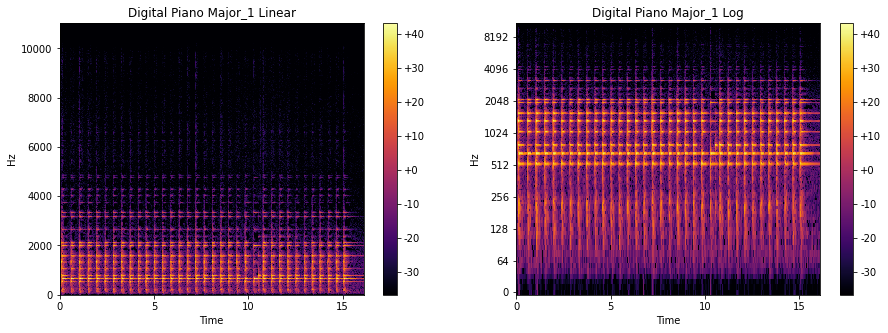

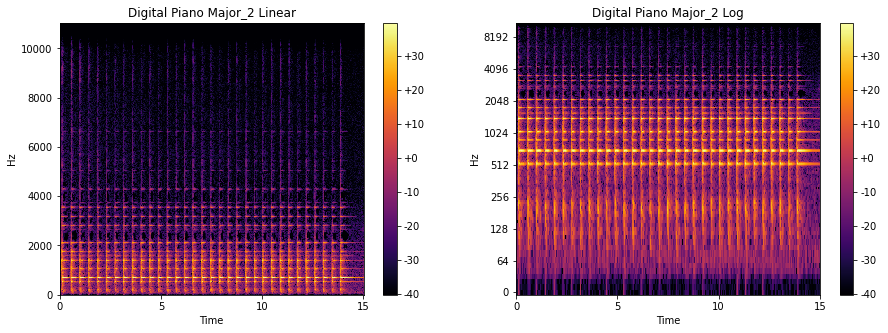

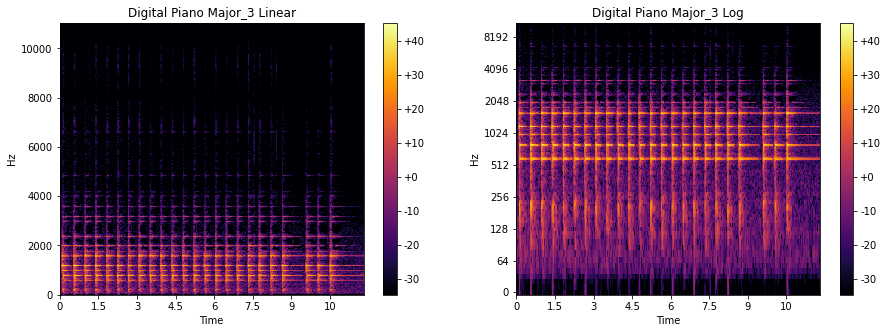

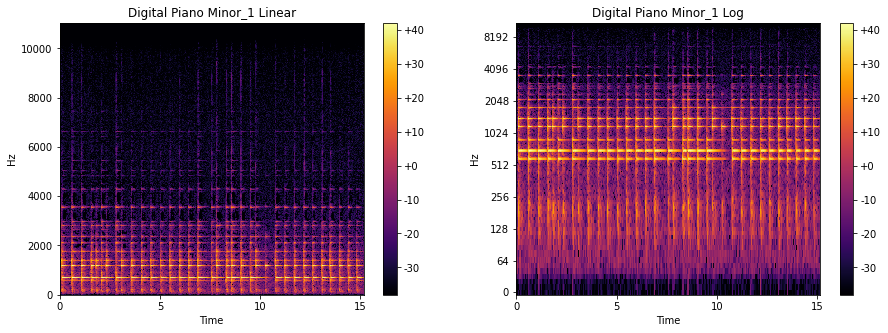

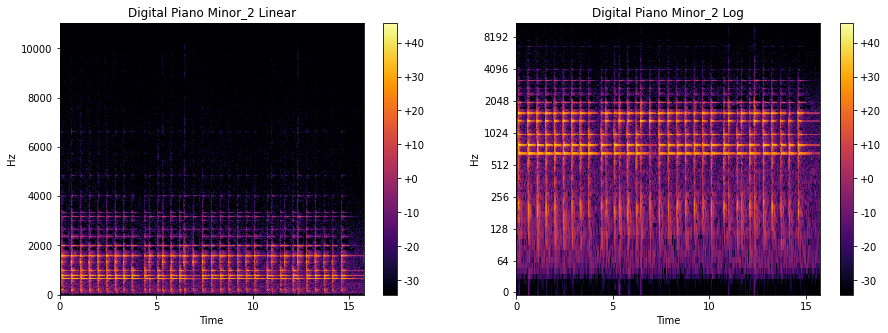

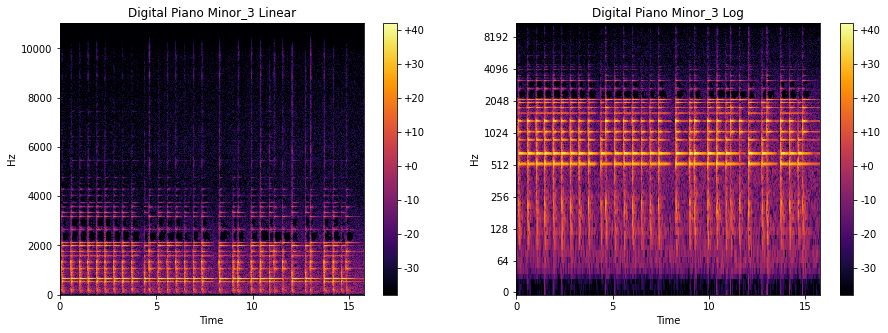

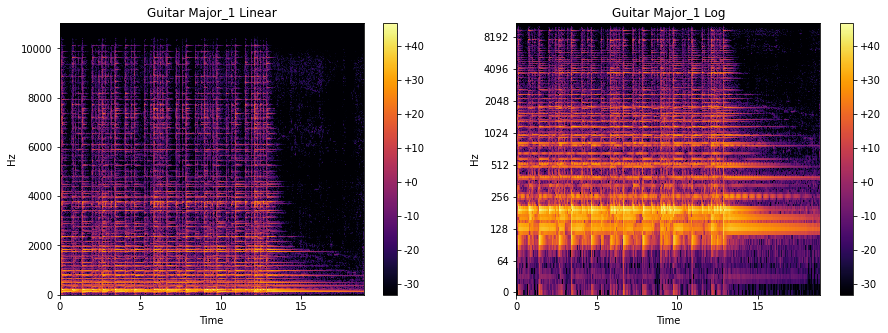

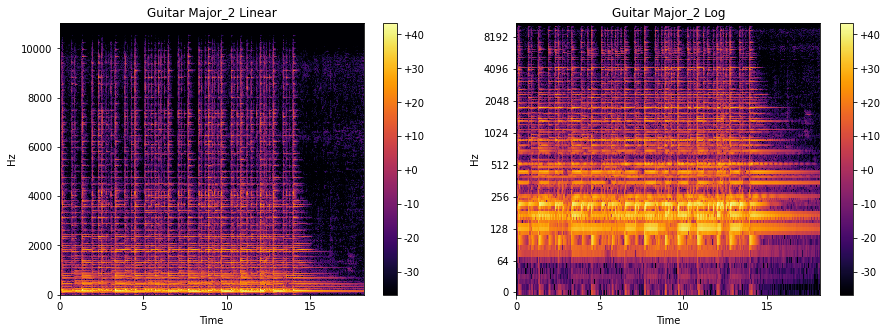

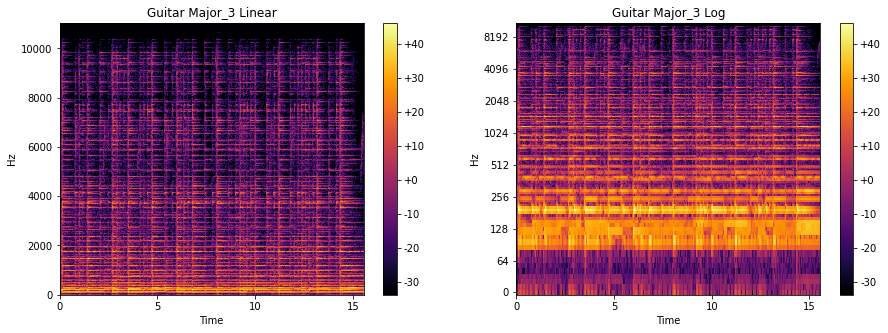

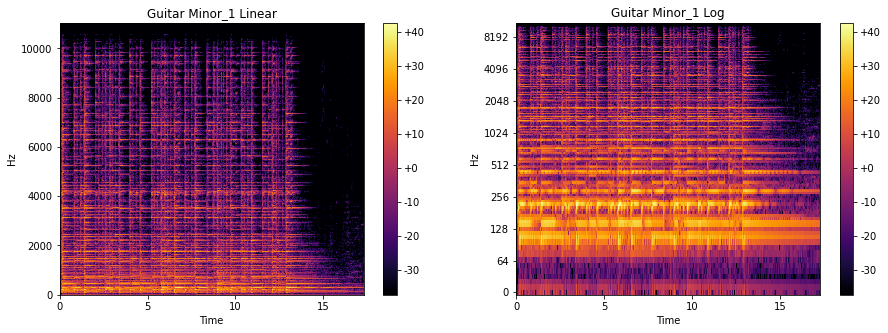

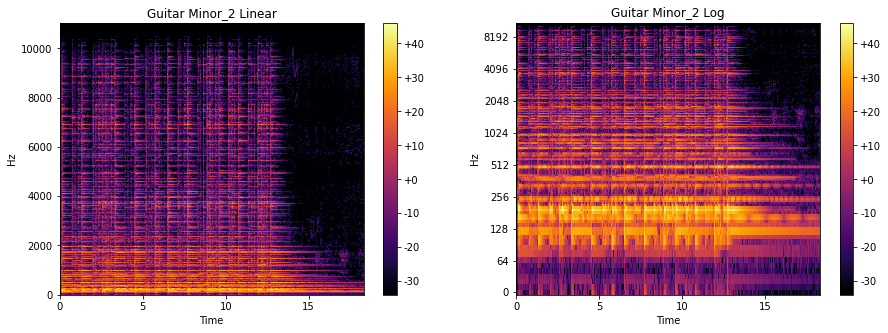

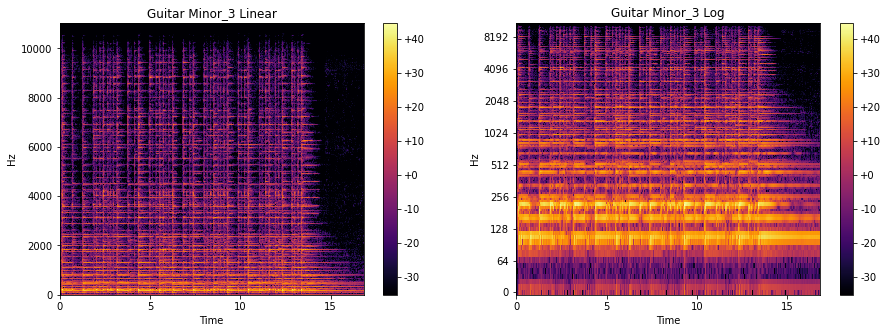

In [41]:
#Plot all the wave file to their Linear and Log Spectrogram

for i, wav in enumerate(audios):
    name = wav.split(".")[0].split("\\")[1]
    file, sr = librosa.load(wav) #load audio
    stft_out = getSTFT(file) 
    spec_out = getSpec(stft_out)
    power_out = getPower(spec_out)
    amp_out = getAmp(spec_out)
    plt.figure(i+1, figsize=(15,5))
    plot_spectrogram(power_out, sr, HOP_SIZE, 121, name + " Linear")
    plot_spectrogram(power_out, sr, HOP_SIZE, 122, name + " Log", y_axis="log")
    plt.show()

# Feature Extraction
Encode the whole spectrogram values to a list( 1 for frequency and 1 for intensity) and visualize it using a histogram.  Then create a data frame with the following columns [`frequency`, `intensity`, `chord`]

#### Frequency and Intensity Histogram

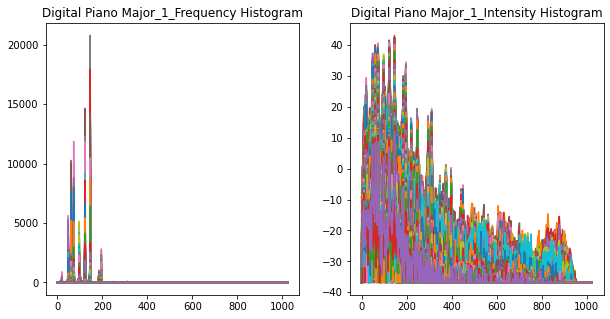

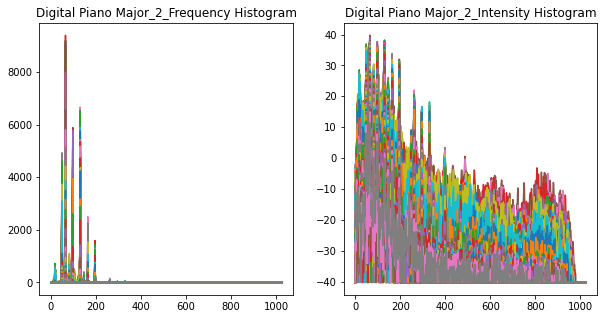

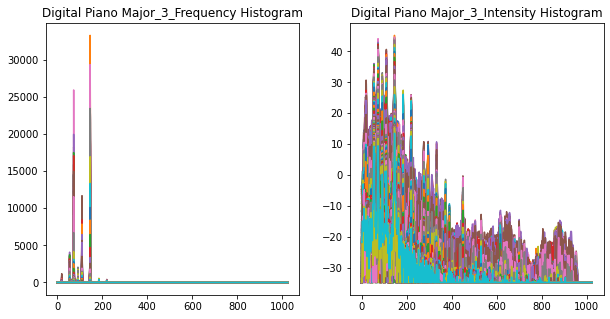

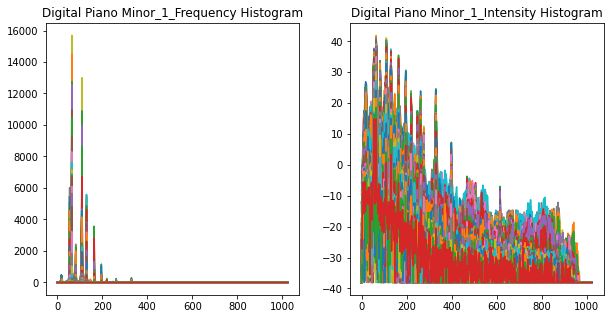

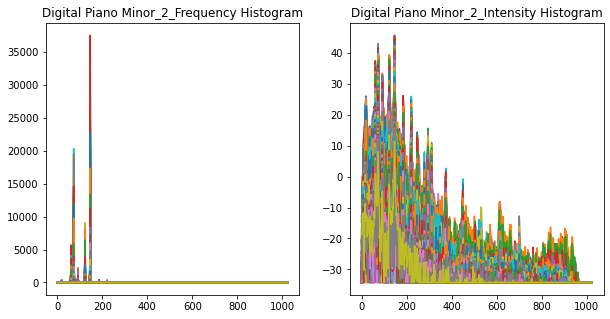

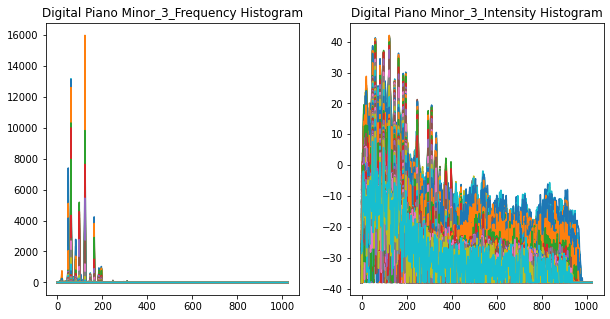

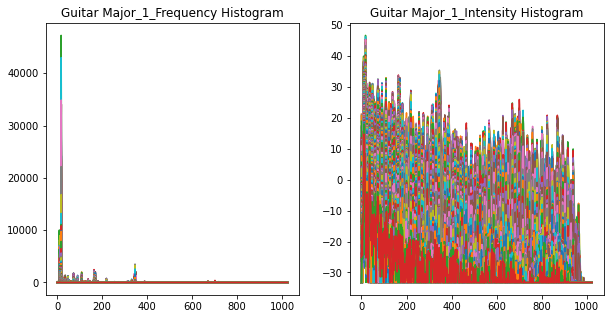

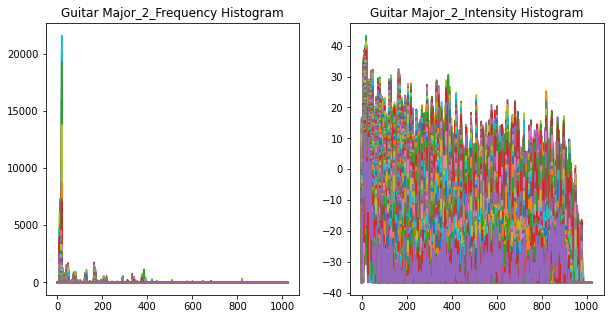

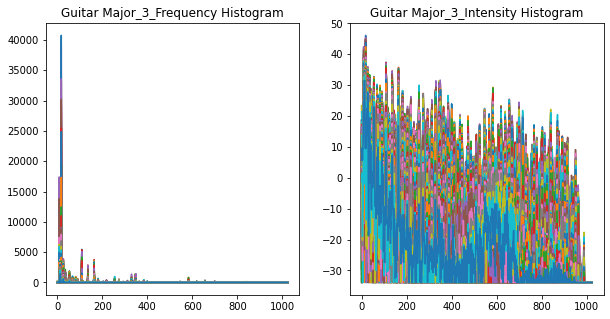

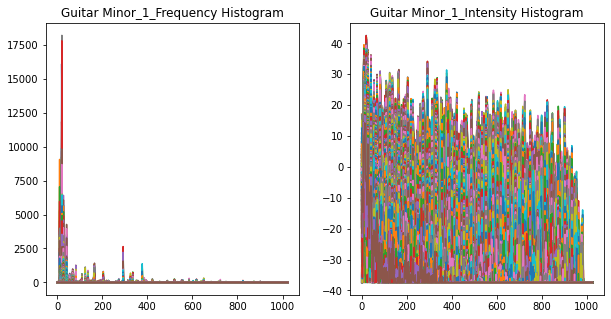

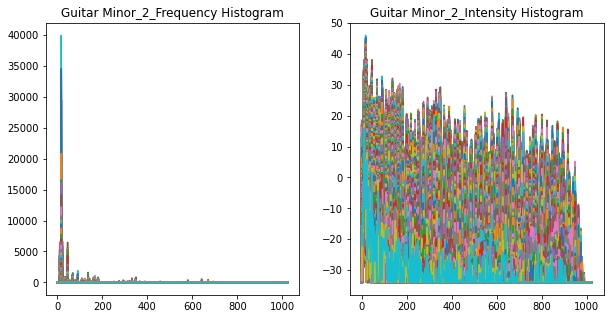

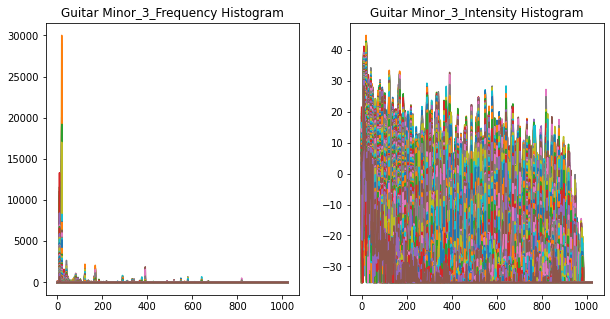

In [43]:
for i, wav in enumerate(audios):
    name = wav.split(".")[0].split("\\")[1]
    file, sr = librosa.load(wav) #load audio
    stft_out = getSTFT(file)
    spec_out = getSpec(stft_out)
    power_out = getPower(spec_out)
    amp_out = getPower(spec_out)

    plt.figure(1+i, figsize=(10,5))
    plt.subplot(121)
    plt.title(name + "_Frequency Histogram")
    plt.plot(spec_out)

    plt.subplot(122)
    plt.title(name + "_Intensity Histogram")
    plt.plot(amp_out)
    plt.show()

#### List of Frequencies and their coressponding notes

In [14]:
# Our hearing range is commonly 20 Hz to 20 kHz
# Starting with 55 Hz which is "A" (I divided 440 by 2 three times)
curr_freq = 55
freq_list = []

# I want to calculate 8 octaves of notes. Each octave has 12 notes. Looping for 96 steps:
for i in range(96): 
    freq_list.append(curr_freq)
    curr_freq *= np.power(2, 1/12) # Multiplying by 2^(1/12)

#reshaping and creating dataframe
freq_array = np.reshape(np.round(freq_list,1), (8, 12))
cols = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
df_note_freqs = pd.DataFrame(freq_array, columns=cols)
print("NOTE FREQUENCIES IN WESTERN MUSIC")
df_note_freqs.head(10)

NOTE FREQUENCIES IN WESTERN MUSIC


A      A#       B       C      C#       D      D#        E        F  \
0    55.0    58.3    61.7    65.4    69.3    73.4    77.8     82.4     87.3   
1   110.0   116.5   123.5   130.8   138.6   146.8   155.6    164.8    174.6   
2   220.0   233.1   246.9   261.6   277.2   293.7   311.1    329.6    349.2   
3   440.0   466.2   493.9   523.3   554.4   587.3   622.3    659.3    698.5   
4   880.0   932.3   987.8  1046.5  1108.7  1174.7  1244.5   1318.5   1396.9   
5  1760.0  1864.7  1975.5  2093.0  2217.5  2349.3  2489.0   2637.0   2793.8   
6  3520.0  3729.3  3951.1  4186.0  4434.9  4698.6  4978.0   5274.0   5587.7   
7  7040.0  7458.6  7902.1  8372.0  8869.8  9397.3  9956.1  10548.1  11175.3   

        F#        G       G#  
0     92.5     98.0    103.8  
1    185.0    196.0    207.7  
2    370.0    392.0    415.3  
3    740.0    784.0    830.6  
4   1480.0   1568.0   1661.2  
5   2960.0   3136.0   3322.4  
6   5919.9   6271.9   6644.9  
7  11839.8  12543.9  13289.8

#### Extract notes

##### Get the Frequencies
Get the frequency that coresponds to a row 

In [44]:
d = librosa.fft_frequencies(sr=sr, n_fft=2048)
DF = pd.DataFrame()
d[0] = 3

##### Extract the Intensities of Frequency per Window

In [45]:
def extractFeature(amp, minDb = -80): #minDb will extract only the frequencies with the specified intensity
    s, t = amp.shape
    Data = pd.DataFrame()

    for i in range(t):
        df = pd.DataFrame()
        p = amp[:,i]
        df['Time'] = [x for x in [i]*1025]
        df['Freq'] = [s for s in d]
        df['Inten'] = [s if s >= minDb else np.nan for s in p]
        df['Note'] = [i for i in librosa.hz_to_note(d)]
        df = df.dropna()
        Data = pd.concat([Data, df])

    return Data

##### Sample extract  a wave file

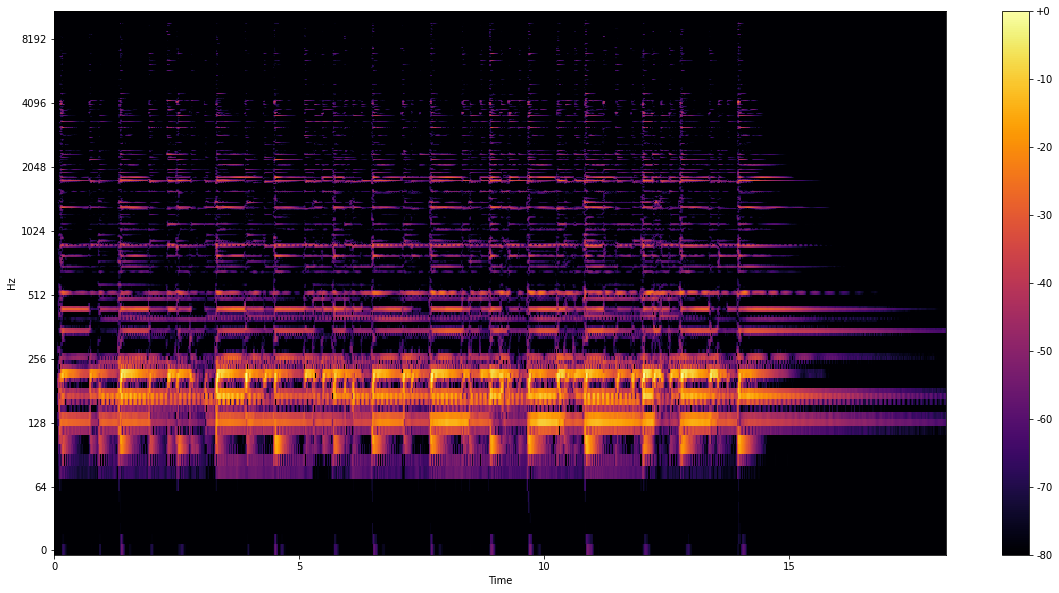

In [46]:
wav = "Audio Chunks/Guitar Major_2.wav"
file, sr = librosa.load(wav) #load audio
stft_out = getSTFT(file) 
spec_out = getSpec(stft_out)
power_out = getPower(spec_out)
amp_out = librosa.amplitude_to_db(spec_out, ref=np.max)
plt.figure(1, figsize=(20,10))
librosa.display.specshow(amp_out, y_axis='log', sr=sr, hop_length=512,
                         x_axis='time', cmap='inferno')
plt.colorbar(format="%+2.f")
plt.show()

In [47]:
Extracted = extractFeature(amp_out, -30)

# To-do 3:  Modelling and Performance Evaluation
Using `decision trees` or `ensemble models` (`scikit learn`), fit a classifier (from the dataframe) using the frequency and intensity as inputs and the chord as output.  Test its accuracy and report if it is sufficient for practical applications.  Check for the predictors (nodes) and report if they could cover the whole spectrum.